In [19]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import pyspark.sql.functions as F
from lstm import SequentialLSTM
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Chapter 1: Exploratory Data Analysis (EDA)

## 1.1. Load data to Spark

In [3]:
spark = SparkSession.builder.appName("Netflix Stock Prediction").getOrCreate()
spark

25/01/15 16:59:23 WARN Utils: Your hostname, WindowEnv resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/15 16:59:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/15 16:59:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [36]:
df = spark.read.csv('./data/NFLX.csv', header=True, inferSchema=True)
print(f'n_rows: {df.count()}; n_cols{len(df.columns)}\n')
df.printSchema()
df.show(10)
for c in df.columns: 
    df.select(c).summary().show()

n_rows: 1009; n_cols7

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
|2018-02-12|252.139999|259.149994|     249.0|257.950012|257.950012| 8534900|
|2018-02-13|257.2900

## 1.2. Data preprocessing

In [5]:
# null-values (no null)
df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns]).show()

# duplicates (no dup)
print(f'Original: {df.count()}, After: {df.drop_duplicates().count()} \n')

# naming convenient
df = df.toDF(*[c.lower() for c in df.columns])
df = df.withColumnRenamed('adj close', 'adj_close')
print(df.columns)

# identify features and target
features = [c for c in df.columns if c not in ['close', 'adj_close', 'date']]

# split data to train and test sets that respect dates order
df = df.orderBy('date')
train_count = int(df.count() * 0.8)
df_train = df.limit(train_count)
df_test = df.subtract(df_train).orderBy('date')

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+

Original: 1009, After: 1009 

['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


25/01/15 16:59:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Chapter 2: Machine learning models

## 2.1. Baseline models

### 2.1.0. Hepler functions

In [14]:
# helper functions
def set_model_params(model, param_map):
    for param, value in param_map.items():
        model.set(param, value)
    return model

# general models training process
def basic_model_train(train_set, test_set, model, evaluator,
                      paramGrid, metrics=['rmse', 'mae', 'r2']):
    min_score = float('inf') # very large float
    best_model = None
    
    for params in paramGrid:
        # set parameters
        model  = set_model_params(model, params)
        
        # train the model
        trained_model = model.fit(train_set)
        
        # evaluate on trainset
        preds_train = trained_model.transform(train_set)
        score = evaluator.evaluate(preds_train)

        # check if current model is the best so far
        if score < min_score:
            best_model = trained_model
            min_score = score
            
    preds_test = best_model.transform(test_set)
    train_metrics = {}
    test_metrics = {}
    for m in metrics:
        test_metrics[m]= evaluator.setMetricName(m).evaluate(preds_test)
        train_metrics[m]= evaluator.setMetricName(m).evaluate(preds_train)
            
    return best_model, train_metrics, test_metrics

### 2.1.1. Data scaling

In [15]:
# create pipeline to process data
assembler = VectorAssembler(inputCols=features, outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
pipeline = Pipeline(stages=[assembler, scaler])

# transform data 
transformer = pipeline.fit(df_train)
train_set = transformer.transform(df_train).select('scaled_features', 'close')
test_set = transformer.transform(df_test).select('scaled_features', 'close')

train_set.show(5)

+--------------------+----------+
|     scaled_features|     close|
+--------------------+----------+
|[0.08056695513173...|254.259995|
|[0.03953748155531...|265.720001|
|[0.09370782339566...|264.559998|
|[0.09514242007289...|250.100006|
|[0.05718304650801...|249.470001|
+--------------------+----------+
only showing top 5 rows



### 2.1.2. Linear regression

In [17]:
lr = LinearRegression(featuresCol='scaled_features', labelCol='close')
ev = RegressionEvaluator(labelCol='close')

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

basic_model_train(train_set, test_set, lr, ev, paramGrid)

(LinearRegressionModel: uid=LinearRegression_97fffa0ba5a3, numFeatures=4,
 {'rmse': 4.904030747425591,
  'mae': 3.730173242009945,
  'r2': 0.9967461541550309},
 {'rmse': 4.142052431879356,
  'mae': 3.0670327679282368,
  'r2': 0.9965362284714888})

### 2.1.3. Decision tree

In [18]:
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='close')
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 64, 128]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 3]) \
    .addGrid(dt.minInfoGain, [0.0, 0.01, 0.02]) \
    .build()

basic_model_train(train_set, test_set, dt, ev, paramGrid)

(DecisionTreeRegressionModel: uid=DecisionTreeRegressor_581a179b3fdf, depth=5, numNodes=63, numFeatures=4,
 {'rmse': 2.8805216729002168,
  'mae': 2.0539959742255283,
  'r2': 0.9988773796790575},
 {'rmse': 51.746953228851126,
  'mae': 33.417115113927466,
  'r2': 0.4593855836498876})

## 2.2. LSTM (Long short-term memory)

### 2.2.0. Helper functions

In [21]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def inverse_scale(scaled_vector, data):
    X_max = data.select('close').rdd.max()[0]
    X_min = data.select('close').rdd.min()[0]
    scaler_min = 0.0
    scaler_max = 1.0
    return (scaler_max * X_min - scaler_min * X_max - X_min * scaled_vector + X_max * scaled_vector) / \
                  (scaler_max - scaler_min)

def predict(model):
    return preds

### 2.2.1. Data processing

In [24]:
# create pipeline to process data
assembler = VectorAssembler(inputCols=['close'], outputCol='feature')
scaler = MinMaxScaler(inputCol='feature', outputCol='scaled_feature')
pipeline = Pipeline(stages=[assembler, scaler])

# transform data 
transformer = pipeline.fit(df_train)
train_set = transformer.transform(df_train).select('scaled_feature')
test_set = transformer.transform(df_test).select('scaled_feature')

# initialize device used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# convert data to numpy array
train_set = train_set.rdd.map(lambda row:row[0][0]).collect()
test_set = test_set.rdd.map(lambda row:row[0][0]).collect()

# get X and y
lookback = 30
X_train, y_train = create_sequences(train_set, lookback)
X_test, y_test = create_sequences(test_set, lookback)

# convert data to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# create dataloader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 2.2.2. Model building

In [26]:
# create model
model = SequentialLSTM(1, 1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss:{train_loss/len(train_loader):.6f}')

Epoch 10/200, Loss:0.003339
Epoch 20/200, Loss:0.002384
Epoch 30/200, Loss:0.001318
Epoch 40/200, Loss:0.001143
Epoch 50/200, Loss:0.000976
Epoch 60/200, Loss:0.001029
Epoch 70/200, Loss:0.001058
Epoch 80/200, Loss:0.000977
Epoch 90/200, Loss:0.001050
Epoch 100/200, Loss:0.001120
Epoch 110/200, Loss:0.001065
Epoch 120/200, Loss:0.000907
Epoch 130/200, Loss:0.001220
Epoch 140/200, Loss:0.001021
Epoch 150/200, Loss:0.000966
Epoch 160/200, Loss:0.000923
Epoch 170/200, Loss:0.000844
Epoch 180/200, Loss:0.000861
Epoch 190/200, Loss:0.000962
Epoch 200/200, Loss:0.000969


### 2.2.3. Evaluating

In [28]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor.unsqueeze(-1)).detach().cpu().numpy()
    y_test_pred = model(X_test_tensor.unsqueeze(-1)).detach().cpu().numpy()

y_train_pred = inverse_scale(y_train_pred, df_train)
y_train = inverse_scale(y_train_tensor.cpu().numpy().reshape(-1, 1), df_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(y_train_pred.shape, train_rmse, train_mae, train_r2)

y_test_pred = inverse_scale(y_test_pred, df_test)
y_test = inverse_scale(y_test_tensor.cpu().numpy().reshape(-1, 1), df_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(y_test_pred.shape, test_rmse, test_mae, test_r2)

(777, 1) 9.638062 7.1022363 0.9872830122000266
(172, 1) 28.491251 20.558224 0.8214974710033505


In [29]:
close = df.select('close').orderBy('date').toPandas()
print(close.head(100))
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred) + lookback, :] = y_train_pred

# Shift test predictions for plotting
testPredictPlot = np.empty_like(close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + (lookback * 2):len(close), :] = y_test_pred

         close
0   254.259995
1   265.720001
2   264.559998
3   250.100006
4   249.470001
..         ...
95  415.440002
96  411.089996
97  384.480011
98  399.390015
99  390.390015

[100 rows x 1 columns]


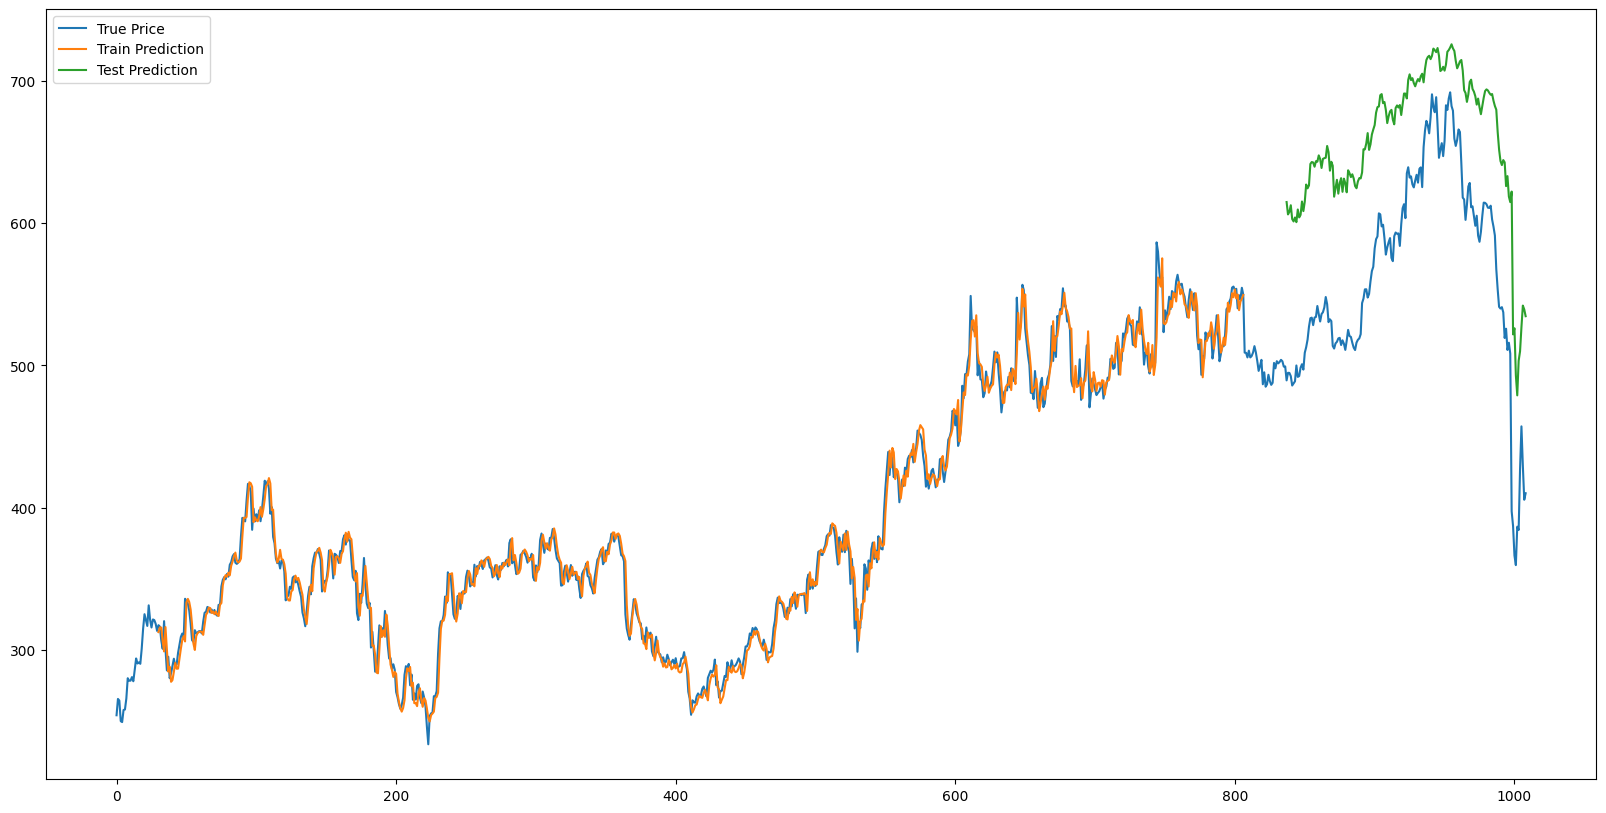

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(close, label='True Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show();